In [28]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import matplotlib.pyplot as plt

mids_dir = Path("D:\\MIDS-W207")
data = mids_dir/"datasets/soccertrack_square"
project = mids_dir/"MIDS-W207-Spring24-Soccer-Detection"
analysis = project/"analysis"

# Author: Timothy Majidzadeh
# Date Created: April 6, 2024
# Date Updated: April 6, 2024
# Description: Try logistic regression on the soccertrack_square dataset.
# Re-uses some code from T. Majidzadeh's Homework 4 submission for MIDS W207 Spring 2024.
# Notes: [v1] Created program. Classes are: {
# Inputs: Frame-by-frame labels saved as separate text files.
# Outputs: An appended DataFrame which randomly selects and shuffles input images for use in machine learning models, with the ball included at a higher rate.

In [22]:
class_dict = {
    0: "No Objects",
    1: "Team 0 Only",
    2: "Team 1 Only",
    3: "Ball Only",
    4: "Team 0 and Team 1",
    5: "Team 0 and Ball",
    6: "Team 1 and Ball",
    7: "Team 0 and Team 1 and Ball"
}
objects_per_image = pd.read_pickle(data/"objects_per_image_oversampled.pkl")

In [23]:
def class_mapping(ball_count, team_0_count, team_1_count):
    '''
    Assigns each row in the objects_per_image DataFrame to a class based on object counts.
    '''
    if (ball_count == 0) & (team_0_count == 0) & (team_1_count == 0):
        return 0
    elif (ball_count == 0) & (team_0_count > 0) & (team_1_count == 0):
        return 1
    elif (ball_count == 0) & (team_0_count == 0) & (team_1_count > 0):
        return 2
    elif (ball_count > 0) & (team_0_count == 0) & (team_1_count == 0):
        return 3
    elif (ball_count == 0) & (team_0_count > 0) & (team_1_count > 0):
        return 4
    elif (ball_count > 0) & (team_0_count > 0) & (team_1_count == 0):
        return 5
    elif (ball_count > 0) & (team_0_count == 0) & (team_1_count > 0):
        return 6
    else:
        return 7

In [24]:
objects_per_image

class,image_name,img_ball_count,img_team_0_count,img_team_1_count
6676,top_view_16005.png,1,2,1
68921,wide_view_24128.png,1,1,0
83641,wide_view_37377.png,1,8,7
59630,wide_view_15767.png,0,0,0
78229,wide_view_32505.png,1,5,3
...,...,...,...,...
68482,wide_view_23733.png,0,0,0
7268,top_view_16539.png,1,2,0
93291,wide_view_46061.png,0,0,0
17450,top_view_25702.png,0,0,0


In [27]:
objects_per_image['class'] = objects_per_image[
    ['img_ball_count', 'img_team_0_count', 'img_team_1_count']
].apply(lambda x: class_mapping(x.img_ball_count, x.img_team_0_count, x.img_team_1_count), axis=1)
objects_per_image

class,image_name,img_ball_count,img_team_0_count,img_team_1_count,class
6676,top_view_16005.png,1,2,1,7
68921,wide_view_24128.png,1,1,0,5
83641,wide_view_37377.png,1,8,7,7
59630,wide_view_15767.png,0,0,0,0
78229,wide_view_32505.png,1,5,3,7
...,...,...,...,...,...
68482,wide_view_23733.png,0,0,0,0
7268,top_view_16539.png,1,2,0,5
93291,wide_view_46061.png,0,0,0,0
17450,top_view_25702.png,0,0,0,0


In [30]:
objects_per_image['class'].unique()

array([7, 5, 0, 6, 3], dtype=int64)

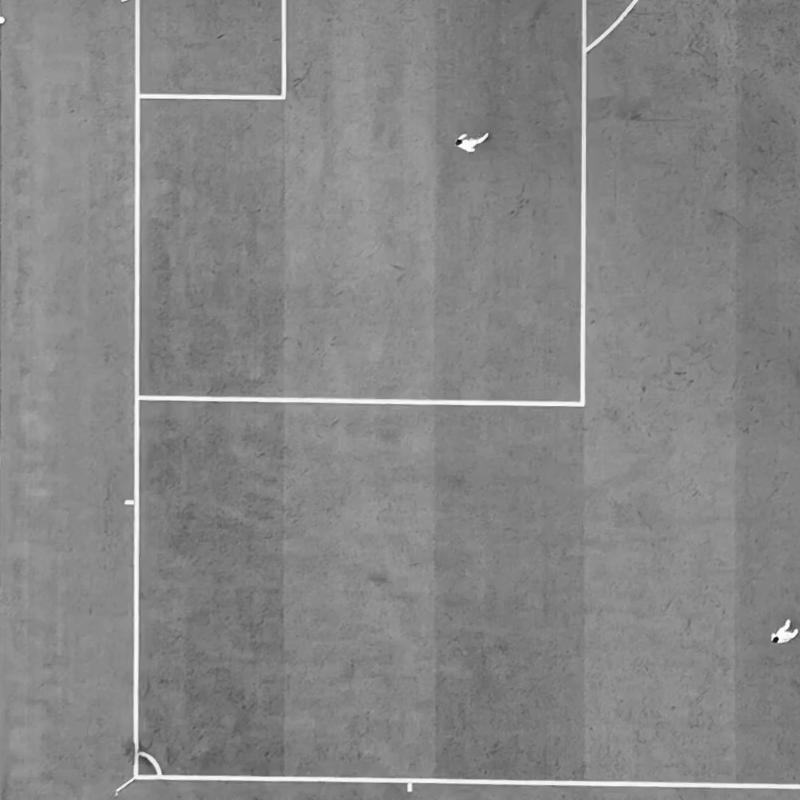

In [32]:
keras.utils.load_img(data/"images/top_view_16005.png", color_mode='grayscale')